## Unsupervised Learning using Approximated Density Ratios

We can estimate any distribution directly by using approximated density ratios. The idea is simple.
To estimate the density ratio $f(x) / g(x)$ we can train a classifier $s(x)$ to discriminate between $f(x)$ and $g(x)$, then we can replace $f(x)/g(x) = f(s(x))/g(s(x))$.
Thus, having data $x \sim g(x)$ we can recover the distribution $f(x)$ by weighting the data by $w = f(s(x))/g(s(x))$.
Now, if we use an uniform distribution as $g(x) = U(x)$ we can estimate any $f(x)$ by:
 - Having data from $x_f \sim f(x)$ we generate data from a uniform distribution $x_g \sim U(x)$
 - Train a classifier to classify between $x_f$ and $x_g$.
 - Compute the ratios $f(s(x))/g((x))$.
 - Reweight data from $x_g \sim U(x)$ using $f(s(x))/g((x))$
 
This can be considered as an alternative to unsupervised learning methods such as GANs, RBM, DBN, autoencoders that try to estimate directly the distribution $f(x)$.

Data generation can be done using the ratio as a cost function and modify an uniformly generated sample in order to maximize the ratio.

We now show how to estimate a simple 1-dim distribution.

In [16]:
import ROOT
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation
from xgboost_wrapper import XGBoostClassifier

import matplotlib.pyplot as plt

from mlp import make_predictions, train_mlp
from utils import printFrame,makePlotName,makeSigBkg,saveFig

import numpy as np

import os

%matplotlib inline

Some global parameters (classifier used, number of features, ...)

In [17]:
workspace_file = 'workspace_transfer.root'
vars_g = ['x']
dir='.'
model_g='mlp'
verbose_printing=False
seed = 1234
rng = np.random.RandomState(seed)

Defining the distribution $f(x)$ being estimated.

In [18]:
# Statistical model
w = ROOT.RooWorkspace('w')
w.factory("EXPR::f0('exp(-(x-3.5)**2/1.)',x[0,15])")
#w.factory("EXPR::f1('exp(-(x-1.5)**2/5.)',x)")

# Check Model
w.Print()
if verbose_printing == True:
     printFrame(w,['x'],[w.pdf('f0')],'transfered',['f0']
    ,dir=dir,model_g=model_g,range=[-15,20],title='Single distributions',x_text='x0',y_text='p(x)',
     print_pdf=True)

Generating data from $f(x)$ and an uniform distributon $g(x)=U(x)$.

Making Data


[]

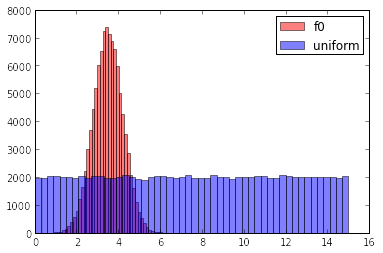

In [19]:
# Start generating data
num_train = 100000
num_test = 5000
num_uniform = 100000
num_train_1 = num_train #f0
num_train_2 = num_uniform #f1

print 'Making Data'
# Start generating data

   
# make data from root pdf
def makeDataFi(x, pdf, num):
    traindata = np.zeros((num,len(vars_g))) 
    data = pdf.generate(x,num)
    traindata[:] = [[data.get(i).getRealValue(var) for var in vars_g]
        for i in range(num)]
    return traindata
  
  # features
vars = ROOT.TList()
for var in vars_g:
    vars.Add(w.var(var))
x = ROOT.RooArgSet(vars)

train_uniform = np.zeros((num_uniform + num_train, len(vars_g) + 1))


data_f0 =  makeDataFi(x,w.pdf('f0'), num_train)
    
random_uniform = rng.uniform(0.,15.,num_uniform)
data_f1 = random_uniform.reshape((random_uniform.shape[0],1))
train_uniform[:num_train,:len(vars_g)] = data_f0
train_uniform[num_train:,:len(vars_g)] = data_f1

train_uniform[:num_uniform,-1] = np.ones(num_uniform)


plt.hist(data_f0,bins=50,color='red',alpha=0.5,label='f0')
plt.hist(data_f1,bins=50,color='blue',alpha=0.5,label='uniform')
plt.legend()
plt.plot()



Train classifier to discriminate between both distributions

In [20]:

model_file = 'train'
n_epochs=40
traindata = train_uniform[:,:-1]
targetdata = train_uniform[:,-1]
if model_g == 'mlp':
    train_mlp((traindata, targetdata), save_file='{0}/{1}_F0_F1.pkl'.format(dir,model_file),n_epochs=n_epochs,
             n_hidden=10)
else:
    indices = rng.permutation(traindata.shape[0])
    traindata = traindata[indices]
    targetdata = targetdata[indices]
    scores = cross_validation.cross_val_score(clf, traindata, targetdata)
    print "Accuracy: {0} (+/- {1})".format(scores.mean(), scores.std() * 2)
    clf.fit(traindata,targetdata)
    #clf.plot_importance_matrix(vars_names)
    joblib.dump(clf, '{0}/{1}_F0_F1.pkl'.format(dir,model_file))


... building the model
... training
Epoch: 1, cost: 28.3283584282
Epoch: 2, cost: 23.9466945679
Epoch: 3, cost: 23.6247479393
Epoch: 4, cost: 23.5082363279
Epoch: 5, cost: 23.4508908966
Epoch: 6, cost: 23.4181287234
Epoch: 7, cost: 23.3973955628
Epoch: 8, cost: 23.3832326497
Epoch: 9, cost: 23.3729204302
Epoch: 10, cost: 23.3649337938
Epoch: 11, cost: 23.3583474324
Epoch: 12, cost: 23.3526217754
Epoch: 13, cost: 23.3475011568
Epoch: 14, cost: 23.3428886398
Epoch: 15, cost: 23.3387361942
Epoch: 16, cost: 23.3349987373
Epoch: 17, cost: 23.3316278759
Epoch: 18, cost: 23.3285757415
Epoch: 19, cost: 23.3257984568
Epoch: 20, cost: 23.3232577189
Epoch: 21, cost: 23.3209210302
Epoch: 22, cost: 23.318761225
Epoch: 23, cost: 23.3167557224
Epoch: 24, cost: 23.314885742
Epoch: 25, cost: 23.3131355941
Epoch: 26, cost: 23.311492081
Epoch: 27, cost: 23.3099440145
Epoch: 28, cost: 23.308481832
Epoch: 29, cost: 23.3070972959
Epoch: 30, cost: 23.3057832574
Epoch: 31, cost: 23.3045334705
Epoch: 32, cost:

In [21]:
# Prediction function 
def predict(filename, traindata,model_g='mlp', sig=1):
  sfilename,k,j = filename.split('/')[-1].split('_')
  sfilename = '/'.join(filename.split('/')[:-1]) + '/' +  sfilename
  j = j.split('.')[0]
  sig = 1
  if k <> 'F0':
    k = int(k)
    j = int(j)
    sig = 1 if k < j else 0
    filename = '{0}_{1}_{2}.pkl'.format(sfilename,min(k,j),max(k,j))
  if model_g == 'mlp':
    return make_predictions(dataset=traindata, model_file=filename,n_hidden=10)[:,sig]
  else:
    clf = joblib.load(filename)
    if clf.__class__.__name__ == 'NuSVR':
      output = clf.predict(traindata)
      return np.clip(output,0.,1.)
    else:
      return clf.predict_proba(traindata)[:,sig]


Estimate distributions $f(s(x))$ and $g(s(x))$.

In [22]:

bins = 80
low = 0.
high = 1.  
c1_g=''
print 'Generating Score Histograms'

w.factory('score[{0},{1}]'.format(low,high))
s = w.var('score')
  
def saveHisto(w,outputs,s,bins,low,high,k='F0',j='F1'):
    
    print 'Estimating {0} {1}'.format(k,j)
    for l,name in enumerate(['sig','bkg']):
      data = ROOT.RooDataSet('{0}data_{1}_{2}'.format(name,k,j),"data",
          ROOT.RooArgSet(s))
      hist = ROOT.TH1F('{0}hist_{1}_{2}'.format(name,k,j),'hist',bins,low,high)
      values = outputs[l]
      #values = values[self.findOutliers(values)]
      for val in values:
        hist.Fill(val)
        s.setVal(val)
        data.add(ROOT.RooArgSet(s))
      norm = 1./hist.Integral()
      hist.Scale(norm) 
        
      s.setBins(bins)
      datahist = ROOT.RooDataHist('{0}datahist_{1}_{2}'.format(name,k,j),'hist',
            ROOT.RooArgList(s),hist)
      histpdf = ROOT.RooHistFunc('{0}histpdf_{1}_{2}'.format(name,k,j),'hist',
            ROOT.RooArgSet(s), datahist, 1)

      getattr(w,'import')(hist)
      getattr(w,'import')(data)
      getattr(w,'import')(datahist) # work around for morph = w.import(morph)
      getattr(w,'import')(histpdf) # work around for morph = w.import(morph)
      score_str = 'score'
      # Calculate the density of the classifier output using kernel density 
      #w.factory('KeysPdf::{0}dist_{1}_{2}({3},{0}data_{1}_{2},RooKeysPdf::NoMirror,2)'.format(name,k,j,score_str))



print 'F0/F1'
outputs = [predict('/afs/cern.ch/work/j/jpavezse/private/transfer_learning/{0}_F0_F1.pkl'.format(model_file),
                   traindata[targetdata==1],model_g=model_g),
            predict('/afs/cern.ch/work/j/jpavezse/private/transfer_learning/{0}_F0_F1.pkl'.format(model_file),
                    traindata[targetdata==0],model_g=model_g)]

saveHisto(w,outputs,s, bins, low, high)

if verbose_printing == True:
    can = printFrame(w,['score'],[w.function('sighistpdf_F0_F1'),w.function('bkghistpdf_F0_F1')], makePlotName('full',
    'all',type='hist',dir=dir,c1_g=c1_g,model_g=model_g),['signal','bkg'],
  dir=dir,model_g=model_g,y_text='score(x)',print_pdf=True,title='Pairwise score distributions',use_rootnotes=False)


Generating Score Histograms
F0/F1
Estimating F0 F1


In [23]:
def findOutliers(x):
  q5, q95 = np.percentile(x, [5,95])  
  iqr = 2.*(q95 - q5)
  outliers = (x <= q95 + iqr) & (x >= q5 - iqr)
  return outliers
def singleRatio(f0,f1):
  ratio = f1 / f0
  ratio[np.abs(ratio) == np.inf] = 0 
  ratio[np.isnan(ratio)] = 0
  return ratio

def evalDist(x,f0,val):
  iter = x.createIterator()
  v = iter.Next()
  i = 0
  while v:
    v.setVal(val[i])
    v = iter.Next()
    i = i+1
  return f0.getVal(x)

Use ratios to weight data from $x_g \sim U(x)$ in order to estimate $f(x)$.

Calculating ratios
[  3.69425049e-05   3.64258265e-05   3.61305817e-05   3.68686937e-05
   3.74222777e-05   3.76080664e-05   6.08559854e-05   1.51015137e-03
   3.71122545e-03   6.25350006e-03   1.32406287e-02   2.33225772e-02
   3.79482793e-02   5.74590258e-02   9.09777977e-02   1.30336816e-01
   1.81442996e-01   2.36441167e-01   3.17240768e-01   3.73749556e-01
   4.82130580e-01   5.39874797e-01   5.35379461e-01   5.46584590e-01
   5.50097558e-01   5.08095438e-01   4.54116620e-01   4.04087989e-01
   3.19197195e-01   2.78904270e-01   1.97559515e-01   1.38016013e-01
   9.36988061e-02   5.95230900e-02   3.67396697e-02   2.26171756e-02
   1.31295104e-02   5.94798399e-03   3.55471503e-03   1.25679119e-03
   6.04221528e-05   3.60258825e-05   3.64258267e-05   3.73853722e-05
   3.57246203e-05   3.71639387e-05   3.64996379e-05   3.74960890e-05
   3.68317883e-05   3.95628026e-05   3.79758618e-05   3.50972251e-05
   3.63151099e-05   3.62043931e-05   3.65365435e-05   3.57984315e-05
   3.68317883e-

[]

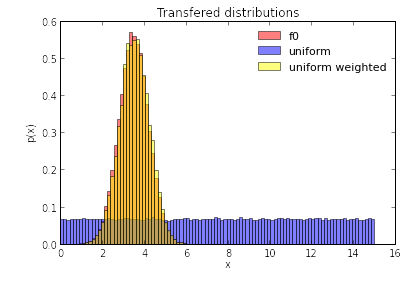

In [24]:

print 'Calculating ratios'
true_dist = False
npoints = 50

score = ROOT.RooArgSet(w.var('score'))
getRatio = singleRatio

# NN trained on complete model
F0pdf = w.function('bkghistpdf_F0_F1')
F1pdf = w.function('sighistpdf_F0_F1')

# Plot ratios
if true_dist == True and len(vars_g) == 1:
    xarray = np.linspace(1.,15.,npoints)
    # TODO: Harcoded dist names
    F1dist = np.array([evalDist(x,w.pdf('f1'),[xs]) for xs in xarray])
    F0dist = np.array([evalDist(x,w.pdf('f0'),[xs]) for xs in xarray])
    trueRatio = getRatio(F1dist, F0dist)

    outputs = predict('{0}/{1}_F0_F1.pkl'.format(dir,model_file),xarray,model_g=model_g)
    F1fulldist = np.array([evalDist(score,F1pdf,[xs]) for xs in outputs])
    F0fulldist = np.array([evalDist(score,F0pdf,[xs]) for xs in outputs])

    completeRatio = getRatio(F0fulldist,F1fulldist)
    
    plt.plot(xarray, completeRatio)
    plt.plot(xarray, trueRatio)
  

# Make transfer learning

# Transforming f1 into f0
data_f1 = train_uniform[train_uniform[:,-1] == 0.]
data_f0 = train_uniform[train_uniform[:,-1] == 1.]
testdata = data_f1[:,:-1]
testtarget = data_f1[:,-1]

outputs = predict('{0}/{1}_F0_F1.pkl'.format(dir,model_file),testdata,model_g=model_g)

F1fulldist = np.array([evalDist(score,F1pdf,[xs]) for xs in outputs])
F0fulldist = np.array([evalDist(score,F0pdf,[xs]) for xs in outputs])

completeRatio = getRatio(F0fulldist,F1fulldist)

bins = 100
feature = 0
x_range = (0.,15.)
# Transfering distributions
# Doing histogram manipulation
fig,ax = plt.subplots()
colors = ['b-','r-','k-']
colors_rgb = ['blue','red','black']
alpha = 0.5
beta = 0.5

hist,bins = np.histogram(data_f1[:,feature],bins=bins, range=x_range,density=True)

hist_transfered_clf,bins_2 = np.histogram(data_f1[:,feature],bins=bins,
                                          weights=completeRatio, range=x_range,density=True)

hist0,bins0 = np.histogram(data_f0[:,feature], bins=bins, range=x_range,density=True)

print hist_transfered_clf

widths = np.diff(bins)

ax.bar(bins[:-1], hist0,widths,label='f0',alpha=0.5,color='red')
ax.bar(bins[:-1], hist,widths,label='uniform',alpha=0.5,color='blue')

ax.bar(bins[:-1], hist_transfered_clf,widths,label='uniform weighted',
        alpha=0.5,color='yellow')


ax.legend(frameon=False,fontsize=11)
ax.set_xlabel('x') 
ax.set_ylabel('p(x)') 
if len(vars_g) > 1:
    ax.set_title('Transfered distributions feature {0}'.format(feature))
else:
    ax.set_title('Transfered distributions')
file_plot =  makePlotName('all','transf',type='hist_v{0}'.format(feature),model_g=model_g) 
fig.savefig('{0}/plots/{1}/{2}.png'.format(dir,model_g,file_plot))

#saveFig(xarray, [true_transfer, data_f0[:,0]], makePlotName('all','transf',type='hist'),title='Transfered distribution',labels=['Transfer True', 'Truth'],hist=True, print_pdf=True,dir=dir)
plt.plot()